# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

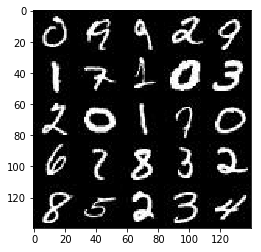

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

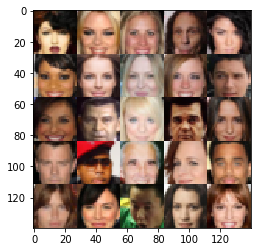

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def normalize_layer(x):
    return x
    mean=tf.reduce_mean(x,axis =[1,2,3], keep_dims = True)
    var = tf.reduce_mean(x*x,axis =[1,2,3], keep_dims = True) - mean*mean
    norm_x = (x - mean)/tf.sqrt(var)
    return norm_x

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    drop_rate = 0.05
    x = images
    with tf.variable_scope('discriminator', reuse=reuse):
        filters = 64
        # Input layer is 28x28x3
        x = tf.layers.conv2d(inputs = x, 
             filters = filters, 
             kernel_size = 5, 
             strides = 1,
             kernel_initializer = tf.contrib.layers.xavier_initializer(),
             padding="same")
        x = tf.layers.dropout(x, drop_rate,training = True)
        x = tf.layers.batch_normalization(x, training = True)
        #x = normalize_layer(x)
        x = tf.concat([images,tf.contrib.keras.layers.LeakyReLU(alpha)(x)],3)
        

        for i in range(3):
            x = tf.layers.conv2d(inputs = x, 
                                 filters = filters, 
                                 kernel_size = 5, 
                                 strides = 2,
                                 kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                 padding="same")
            x = tf.layers.dropout(x, drop_rate,training = True)
            x = tf.layers.batch_normalization(x, training = True)
            #x = normalize_layer(x)
            x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
            
            filters = 2*filters
        #print(x.get_shape().as_list())
        flat = tf.contrib.layers.flatten(x)
        x = tf.layers.dropout(x, drop_rate,training = True)
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [24]:
def generator(z, out_channel_dim, is_train=True):
    # Why on earth does the test check for the number of args?
    alpha = 0.2
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    init_filters = 512
    init_dim =[-1,7,7,init_filters]
    init_len = 7*7*init_filters
    filters = init_filters
    drop_rate = 0.5
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x = tf.layers.dense(z,init_len)
        x = tf.reshape(x, tf.cast(init_dim, tf.int32))
        x = tf.layers.dropout(x, drop_rate, training = is_train)
        x = tf.layers.batch_normalization(x, training = is_train)
        #x = normalize_layer(x)
        x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
        
        
        # so now we're at 7x7x512
        for i in range(2):
            filters = filters/2
            x = tf.layers.conv2d_transpose(inputs = x, 
                                           filters = int(filters), 
                                           kernel_size =5,
                                           strides = 2,
                                           kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                           padding = 'same')
            x = tf.layers.dropout(x, drop_rate, training = is_train)
            x = tf.layers.batch_normalization(x, training = is_train)
            #x = normalize_layer(x)
            x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
           
            
        x = tf.layers.conv2d_transpose(inputs = x, 
                                   filters = out_channel_dim, 
                                   kernel_size = 5,
                                   strides = 1,
                                   kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                   padding = 'same')
        #x = tf.layers.batch_normalization(x, training = is_train)
        # Output layer, 28x28x3 
        # rather than mess around with convolutions to get the size just right, let's just trim it
        #logits = tf.slice(x, [0,0,0,0],[-1,28,28,-1])
        logits = x
        out = 0.5*tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [25]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    label_smooth = 0.2
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=(1-label_smooth)*tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    dummy, image_width, image_height, out_channel_dim =  data_shape
    input_real, input_z, learning_rate_ph = model_inputs(image_width, image_height, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
                
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1,epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z,out_channel_dim, is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 9, input_z, out_channel_dim, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
    import pickle
    with open('samples.pkl', 'wb') as f:
        pickle.dump(samples, f)
    
    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5483... Generator Loss: 4.3748
Epoch 1/2... Discriminator Loss: 0.5770... Generator Loss: 4.4019
Epoch 1/2... Discriminator Loss: 0.8268... Generator Loss: 3.1428
Epoch 1/2... Discriminator Loss: 0.6306... Generator Loss: 3.6720
Epoch 1/2... Discriminator Loss: 0.6265... Generator Loss: 3.3600
Epoch 1/2... Discriminator Loss: 0.6065... Generator Loss: 3.4959
Epoch 1/2... Discriminator Loss: 0.9704... Generator Loss: 2.1421
Epoch 1/2... Discriminator Loss: 0.5520... Generator Loss: 4.3665
Epoch 1/2... Discriminator Loss: 2.1433... Generator Loss: 10.1900
Epoch 1/2... Discriminator Loss: 0.5521... Generator Loss: 4.8775


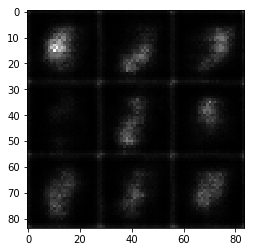

Epoch 1/2... Discriminator Loss: 0.5473... Generator Loss: 4.2742
Epoch 1/2... Discriminator Loss: 0.6025... Generator Loss: 3.0451
Epoch 1/2... Discriminator Loss: 1.9745... Generator Loss: 7.8072
Epoch 1/2... Discriminator Loss: 0.6239... Generator Loss: 3.5057
Epoch 1/2... Discriminator Loss: 0.6358... Generator Loss: 3.2746
Epoch 1/2... Discriminator Loss: 0.6872... Generator Loss: 3.8400
Epoch 1/2... Discriminator Loss: 0.6753... Generator Loss: 2.9726
Epoch 1/2... Discriminator Loss: 0.6007... Generator Loss: 3.3684
Epoch 1/2... Discriminator Loss: 0.6022... Generator Loss: 4.2213
Epoch 1/2... Discriminator Loss: 1.5010... Generator Loss: 6.2526


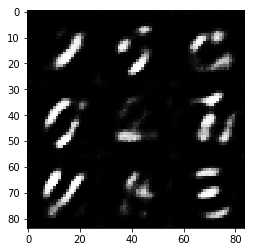

Epoch 1/2... Discriminator Loss: 0.5801... Generator Loss: 3.3982
Epoch 1/2... Discriminator Loss: 0.7377... Generator Loss: 4.7535
Epoch 1/2... Discriminator Loss: 0.6091... Generator Loss: 3.1698
Epoch 1/2... Discriminator Loss: 0.6207... Generator Loss: 3.5930
Epoch 1/2... Discriminator Loss: 0.6307... Generator Loss: 3.6279
Epoch 1/2... Discriminator Loss: 0.6933... Generator Loss: 4.5565
Epoch 1/2... Discriminator Loss: 0.5945... Generator Loss: 3.5828
Epoch 1/2... Discriminator Loss: 1.6359... Generator Loss: 0.9250
Epoch 1/2... Discriminator Loss: 0.6229... Generator Loss: 3.7568
Epoch 1/2... Discriminator Loss: 0.5813... Generator Loss: 3.6181


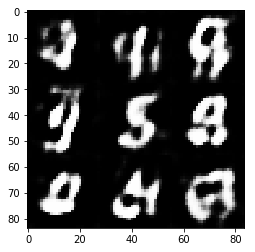

Epoch 1/2... Discriminator Loss: 0.6071... Generator Loss: 3.4281
Epoch 1/2... Discriminator Loss: 0.5803... Generator Loss: 3.3793
Epoch 1/2... Discriminator Loss: 0.7706... Generator Loss: 4.6674
Epoch 1/2... Discriminator Loss: 0.6393... Generator Loss: 3.1520
Epoch 1/2... Discriminator Loss: 0.5994... Generator Loss: 3.4033
Epoch 1/2... Discriminator Loss: 0.6867... Generator Loss: 2.5256
Epoch 1/2... Discriminator Loss: 0.5790... Generator Loss: 3.4668
Epoch 1/2... Discriminator Loss: 0.6030... Generator Loss: 3.0923
Epoch 1/2... Discriminator Loss: 0.5927... Generator Loss: 4.0792
Epoch 1/2... Discriminator Loss: 0.5654... Generator Loss: 3.7374


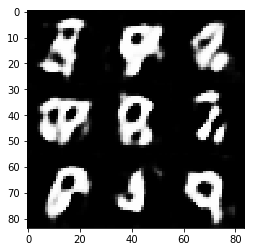

Epoch 1/2... Discriminator Loss: 0.6145... Generator Loss: 4.3423
Epoch 1/2... Discriminator Loss: 0.5763... Generator Loss: 3.9608
Epoch 1/2... Discriminator Loss: 0.5909... Generator Loss: 3.4350
Epoch 1/2... Discriminator Loss: 0.5850... Generator Loss: 3.4197
Epoch 1/2... Discriminator Loss: 0.5744... Generator Loss: 3.8980
Epoch 1/2... Discriminator Loss: 0.6598... Generator Loss: 3.7452
Epoch 2/2... Discriminator Loss: 0.5768... Generator Loss: 4.3701
Epoch 2/2... Discriminator Loss: 0.6172... Generator Loss: 5.0801
Epoch 2/2... Discriminator Loss: 0.6637... Generator Loss: 4.5983
Epoch 2/2... Discriminator Loss: 0.5814... Generator Loss: 3.4093


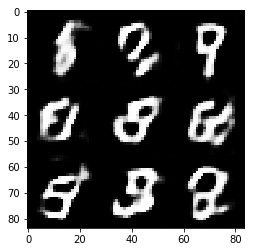

Epoch 2/2... Discriminator Loss: 0.5801... Generator Loss: 3.6879
Epoch 2/2... Discriminator Loss: 0.5757... Generator Loss: 3.7295
Epoch 2/2... Discriminator Loss: 0.7095... Generator Loss: 2.9266
Epoch 2/2... Discriminator Loss: 0.5710... Generator Loss: 3.8903
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 1.5441
Epoch 2/2... Discriminator Loss: 0.6245... Generator Loss: 2.9567
Epoch 2/2... Discriminator Loss: 0.5730... Generator Loss: 4.3392
Epoch 2/2... Discriminator Loss: 0.5728... Generator Loss: 3.7472
Epoch 2/2... Discriminator Loss: 0.5702... Generator Loss: 4.0372
Epoch 2/2... Discriminator Loss: 0.6283... Generator Loss: 5.0555


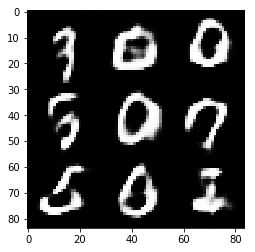

Epoch 2/2... Discriminator Loss: 0.5660... Generator Loss: 4.5808
Epoch 2/2... Discriminator Loss: 0.6393... Generator Loss: 4.8051
Epoch 2/2... Discriminator Loss: 0.6059... Generator Loss: 2.9969
Epoch 2/2... Discriminator Loss: 0.6162... Generator Loss: 4.6312
Epoch 2/2... Discriminator Loss: 0.6169... Generator Loss: 3.3062
Epoch 2/2... Discriminator Loss: 1.0697... Generator Loss: 1.3713
Epoch 2/2... Discriminator Loss: 0.5800... Generator Loss: 3.4122
Epoch 2/2... Discriminator Loss: 0.5749... Generator Loss: 3.8016
Epoch 2/2... Discriminator Loss: 0.5656... Generator Loss: 3.8157
Epoch 2/2... Discriminator Loss: 0.5704... Generator Loss: 3.8730


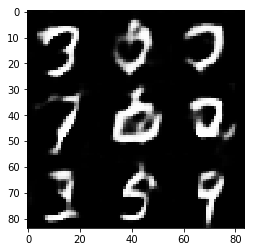

Epoch 2/2... Discriminator Loss: 0.5711... Generator Loss: 3.8383
Epoch 2/2... Discriminator Loss: 0.5545... Generator Loss: 3.5743
Epoch 2/2... Discriminator Loss: 0.5672... Generator Loss: 4.5668
Epoch 2/2... Discriminator Loss: 0.5868... Generator Loss: 3.1833
Epoch 2/2... Discriminator Loss: 0.5674... Generator Loss: 3.8266
Epoch 2/2... Discriminator Loss: 0.5657... Generator Loss: 4.1328
Epoch 2/2... Discriminator Loss: 0.6037... Generator Loss: 3.2427
Epoch 2/2... Discriminator Loss: 0.9417... Generator Loss: 1.8060
Epoch 2/2... Discriminator Loss: 0.5789... Generator Loss: 3.6031
Epoch 2/2... Discriminator Loss: 1.1116... Generator Loss: 6.1194


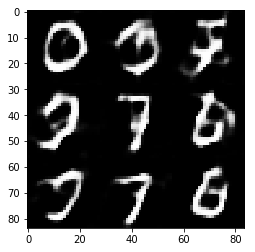

Epoch 2/2... Discriminator Loss: 0.5984... Generator Loss: 3.0981
Epoch 2/2... Discriminator Loss: 0.6161... Generator Loss: 3.2564
Epoch 2/2... Discriminator Loss: 0.5767... Generator Loss: 4.1894
Epoch 2/2... Discriminator Loss: 0.7544... Generator Loss: 5.2546
Epoch 2/2... Discriminator Loss: 0.6215... Generator Loss: 3.0314
Epoch 2/2... Discriminator Loss: 0.6355... Generator Loss: 4.9671
Epoch 2/2... Discriminator Loss: 0.6249... Generator Loss: 3.0966
Epoch 2/2... Discriminator Loss: 0.6334... Generator Loss: 4.5739
Epoch 2/2... Discriminator Loss: 0.6380... Generator Loss: 2.6023
Epoch 2/2... Discriminator Loss: 0.5699... Generator Loss: 4.2684


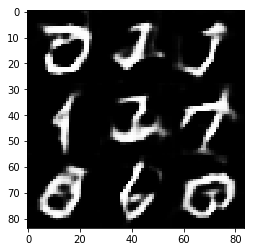

Epoch 2/2... Discriminator Loss: 0.5969... Generator Loss: 3.3988
Epoch 2/2... Discriminator Loss: 0.5996... Generator Loss: 4.2795
Epoch 2/2... Discriminator Loss: 0.5892... Generator Loss: 3.8823


In [22]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
print_every = 10
show_every= 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/5... Discriminator Loss: 0.7518... Generator Loss: 4.2356
Epoch 1/5... Discriminator Loss: 0.5975... Generator Loss: 3.9815
Epoch 1/5... Discriminator Loss: 0.6025... Generator Loss: 3.4605
Epoch 1/5... Discriminator Loss: 1.1147... Generator Loss: 2.1636
Epoch 1/5... Discriminator Loss: 0.6391... Generator Loss: 5.3614
Epoch 1/5... Discriminator Loss: 0.6312... Generator Loss: 2.8401
Epoch 1/5... Discriminator Loss: 0.7169... Generator Loss: 2.4864
Epoch 1/5... Discriminator Loss: 0.5911... Generator Loss: 4.5631
Epoch 1/5... Discriminator Loss: 0.6015... Generator Loss: 3.8210
Epoch 1/5... Discriminator Loss: 0.6801... Generator Loss: 2.4660


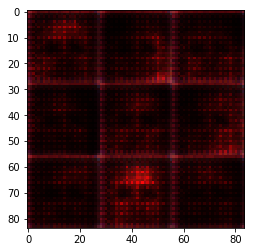

Epoch 1/5... Discriminator Loss: 0.5506... Generator Loss: 5.2409
Epoch 1/5... Discriminator Loss: 0.5539... Generator Loss: 4.3018
Epoch 1/5... Discriminator Loss: 0.6818... Generator Loss: 2.8807
Epoch 1/5... Discriminator Loss: 0.5435... Generator Loss: 5.3589
Epoch 1/5... Discriminator Loss: 0.8045... Generator Loss: 5.5390
Epoch 1/5... Discriminator Loss: 0.5561... Generator Loss: 4.4459
Epoch 1/5... Discriminator Loss: 0.5930... Generator Loss: 5.6479
Epoch 1/5... Discriminator Loss: 0.6092... Generator Loss: 4.6392
Epoch 1/5... Discriminator Loss: 0.5464... Generator Loss: 4.8769
Epoch 1/5... Discriminator Loss: 0.5358... Generator Loss: 5.0869


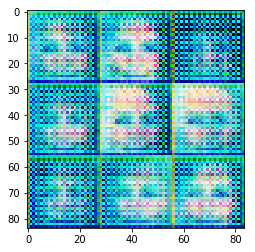

Epoch 1/5... Discriminator Loss: 0.5879... Generator Loss: 3.1464
Epoch 1/5... Discriminator Loss: 0.5425... Generator Loss: 5.7066
Epoch 1/5... Discriminator Loss: 0.5481... Generator Loss: 4.0889
Epoch 1/5... Discriminator Loss: 0.5354... Generator Loss: 5.5540
Epoch 1/5... Discriminator Loss: 0.5535... Generator Loss: 4.9054
Epoch 1/5... Discriminator Loss: 0.5390... Generator Loss: 4.0538
Epoch 1/5... Discriminator Loss: 0.5331... Generator Loss: 4.7226
Epoch 1/5... Discriminator Loss: 0.5281... Generator Loss: 4.8219
Epoch 1/5... Discriminator Loss: 0.5615... Generator Loss: 5.3647
Epoch 1/5... Discriminator Loss: 0.8511... Generator Loss: 1.9754


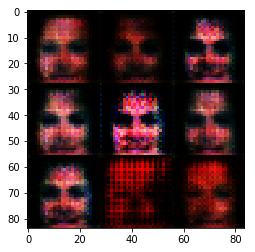

Epoch 1/5... Discriminator Loss: 1.1621... Generator Loss: 4.5761
Epoch 1/5... Discriminator Loss: 0.5954... Generator Loss: 3.3223
Epoch 1/5... Discriminator Loss: 0.5940... Generator Loss: 3.8857
Epoch 1/5... Discriminator Loss: 1.0860... Generator Loss: 1.0579
Epoch 1/5... Discriminator Loss: 0.7297... Generator Loss: 2.1511
Epoch 1/5... Discriminator Loss: 0.6117... Generator Loss: 2.9099
Epoch 1/5... Discriminator Loss: 0.5999... Generator Loss: 3.2459
Epoch 1/5... Discriminator Loss: 0.6450... Generator Loss: 2.4762
Epoch 1/5... Discriminator Loss: 0.7316... Generator Loss: 3.2836
Epoch 1/5... Discriminator Loss: 0.7672... Generator Loss: 3.9917


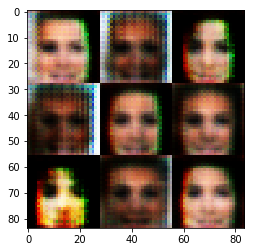

Epoch 1/5... Discriminator Loss: 1.1124... Generator Loss: 3.9018
Epoch 1/5... Discriminator Loss: 0.7929... Generator Loss: 3.0465
Epoch 1/5... Discriminator Loss: 0.7156... Generator Loss: 2.6074
Epoch 1/5... Discriminator Loss: 0.6384... Generator Loss: 2.7177
Epoch 1/5... Discriminator Loss: 0.6470... Generator Loss: 3.6233
Epoch 1/5... Discriminator Loss: 0.6503... Generator Loss: 2.8579
Epoch 1/5... Discriminator Loss: 0.6202... Generator Loss: 3.0938
Epoch 1/5... Discriminator Loss: 0.8623... Generator Loss: 2.4918
Epoch 1/5... Discriminator Loss: 0.7585... Generator Loss: 2.0308
Epoch 1/5... Discriminator Loss: 0.6019... Generator Loss: 3.3699


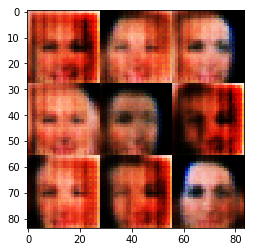

Epoch 1/5... Discriminator Loss: 0.7469... Generator Loss: 3.1038
Epoch 1/5... Discriminator Loss: 0.7091... Generator Loss: 2.1854
Epoch 1/5... Discriminator Loss: 0.6136... Generator Loss: 3.0882
Epoch 1/5... Discriminator Loss: 0.8629... Generator Loss: 4.1082
Epoch 1/5... Discriminator Loss: 0.7444... Generator Loss: 1.9727
Epoch 1/5... Discriminator Loss: 0.7476... Generator Loss: 2.1827
Epoch 1/5... Discriminator Loss: 0.6991... Generator Loss: 2.6924
Epoch 1/5... Discriminator Loss: 0.7742... Generator Loss: 1.8499
Epoch 1/5... Discriminator Loss: 0.7280... Generator Loss: 2.0568
Epoch 1/5... Discriminator Loss: 1.0824... Generator Loss: 1.3264


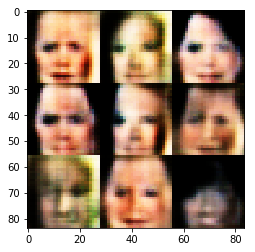

Epoch 1/5... Discriminator Loss: 0.7279... Generator Loss: 2.9748
Epoch 1/5... Discriminator Loss: 1.2353... Generator Loss: 5.5644
Epoch 1/5... Discriminator Loss: 0.9253... Generator Loss: 3.0847
Epoch 1/5... Discriminator Loss: 0.7198... Generator Loss: 2.7932
Epoch 1/5... Discriminator Loss: 0.6555... Generator Loss: 3.0239
Epoch 1/5... Discriminator Loss: 0.7291... Generator Loss: 2.4225
Epoch 1/5... Discriminator Loss: 0.8537... Generator Loss: 2.5708
Epoch 1/5... Discriminator Loss: 0.9474... Generator Loss: 3.6717
Epoch 1/5... Discriminator Loss: 0.7597... Generator Loss: 3.4728
Epoch 1/5... Discriminator Loss: 0.7803... Generator Loss: 1.9987


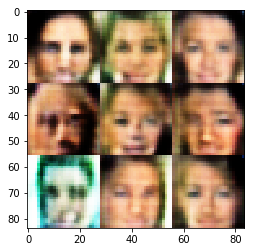

Epoch 1/5... Discriminator Loss: 0.7999... Generator Loss: 2.1174
Epoch 1/5... Discriminator Loss: 1.0394... Generator Loss: 1.4156
Epoch 1/5... Discriminator Loss: 0.8329... Generator Loss: 2.1303
Epoch 1/5... Discriminator Loss: 0.8261... Generator Loss: 3.1329
Epoch 1/5... Discriminator Loss: 0.8662... Generator Loss: 1.6479
Epoch 1/5... Discriminator Loss: 1.0989... Generator Loss: 4.2308
Epoch 1/5... Discriminator Loss: 0.7988... Generator Loss: 2.6795
Epoch 1/5... Discriminator Loss: 0.9251... Generator Loss: 1.5243
Epoch 1/5... Discriminator Loss: 0.9334... Generator Loss: 2.6892
Epoch 1/5... Discriminator Loss: 0.7862... Generator Loss: 2.1709


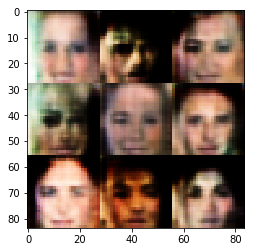

Epoch 1/5... Discriminator Loss: 1.0434... Generator Loss: 1.1049
Epoch 1/5... Discriminator Loss: 0.7400... Generator Loss: 2.6753
Epoch 1/5... Discriminator Loss: 1.2370... Generator Loss: 3.5649
Epoch 1/5... Discriminator Loss: 0.8816... Generator Loss: 1.7855
Epoch 1/5... Discriminator Loss: 1.0277... Generator Loss: 1.2144
Epoch 1/5... Discriminator Loss: 1.6273... Generator Loss: 4.0067
Epoch 1/5... Discriminator Loss: 0.9140... Generator Loss: 2.3375
Epoch 1/5... Discriminator Loss: 0.9475... Generator Loss: 1.1801
Epoch 1/5... Discriminator Loss: 0.8492... Generator Loss: 1.7838
Epoch 1/5... Discriminator Loss: 0.8296... Generator Loss: 2.3407


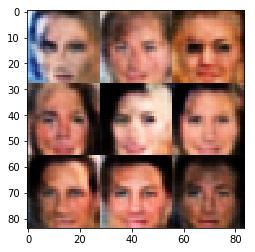

Epoch 1/5... Discriminator Loss: 0.9011... Generator Loss: 1.5031
Epoch 1/5... Discriminator Loss: 1.1483... Generator Loss: 3.0073
Epoch 1/5... Discriminator Loss: 1.0137... Generator Loss: 2.2616
Epoch 1/5... Discriminator Loss: 1.3486... Generator Loss: 0.8535
Epoch 1/5... Discriminator Loss: 0.8164... Generator Loss: 1.7481
Epoch 1/5... Discriminator Loss: 1.0235... Generator Loss: 1.1336
Epoch 1/5... Discriminator Loss: 0.8900... Generator Loss: 1.4613
Epoch 1/5... Discriminator Loss: 1.6269... Generator Loss: 3.9217
Epoch 1/5... Discriminator Loss: 0.8764... Generator Loss: 1.7610
Epoch 1/5... Discriminator Loss: 0.8325... Generator Loss: 1.8140


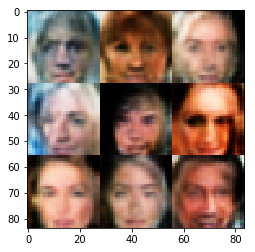

Epoch 1/5... Discriminator Loss: 0.9259... Generator Loss: 1.3380
Epoch 1/5... Discriminator Loss: 1.1952... Generator Loss: 2.9829
Epoch 1/5... Discriminator Loss: 0.9189... Generator Loss: 1.4849
Epoch 1/5... Discriminator Loss: 1.1959... Generator Loss: 2.9483
Epoch 1/5... Discriminator Loss: 0.9014... Generator Loss: 1.4596
Epoch 1/5... Discriminator Loss: 0.9024... Generator Loss: 1.2460
Epoch 1/5... Discriminator Loss: 0.9904... Generator Loss: 2.6801
Epoch 1/5... Discriminator Loss: 0.8225... Generator Loss: 2.0153
Epoch 1/5... Discriminator Loss: 0.7747... Generator Loss: 2.1196
Epoch 1/5... Discriminator Loss: 0.8688... Generator Loss: 1.5273


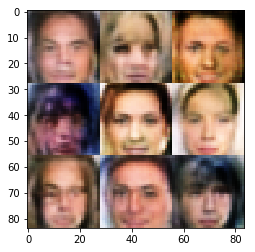

Epoch 1/5... Discriminator Loss: 0.8938... Generator Loss: 1.5326
Epoch 1/5... Discriminator Loss: 0.9187... Generator Loss: 3.0676
Epoch 1/5... Discriminator Loss: 0.7915... Generator Loss: 2.2827
Epoch 1/5... Discriminator Loss: 1.1659... Generator Loss: 2.7235
Epoch 1/5... Discriminator Loss: 0.8679... Generator Loss: 1.5721
Epoch 1/5... Discriminator Loss: 1.0775... Generator Loss: 2.3278
Epoch 1/5... Discriminator Loss: 0.8697... Generator Loss: 1.5025
Epoch 1/5... Discriminator Loss: 0.8123... Generator Loss: 2.0831
Epoch 1/5... Discriminator Loss: 0.8901... Generator Loss: 1.4656
Epoch 1/5... Discriminator Loss: 1.1320... Generator Loss: 2.6482


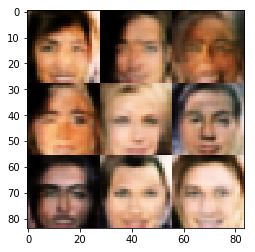

Epoch 1/5... Discriminator Loss: 0.8205... Generator Loss: 2.3991
Epoch 1/5... Discriminator Loss: 1.0347... Generator Loss: 1.1361
Epoch 1/5... Discriminator Loss: 0.9969... Generator Loss: 1.4380
Epoch 1/5... Discriminator Loss: 1.0878... Generator Loss: 2.9395
Epoch 1/5... Discriminator Loss: 1.0022... Generator Loss: 2.2406
Epoch 1/5... Discriminator Loss: 0.9123... Generator Loss: 1.3716
Epoch 1/5... Discriminator Loss: 0.8859... Generator Loss: 1.7533
Epoch 1/5... Discriminator Loss: 0.9434... Generator Loss: 1.8523
Epoch 1/5... Discriminator Loss: 0.9859... Generator Loss: 1.2090
Epoch 1/5... Discriminator Loss: 0.8707... Generator Loss: 1.5515


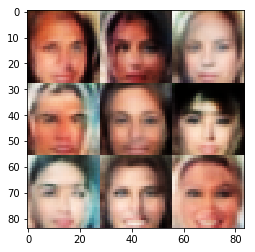

Epoch 1/5... Discriminator Loss: 0.9719... Generator Loss: 2.6432
Epoch 1/5... Discriminator Loss: 1.5470... Generator Loss: 0.5895
Epoch 1/5... Discriminator Loss: 0.9123... Generator Loss: 1.4513
Epoch 1/5... Discriminator Loss: 0.9559... Generator Loss: 1.5650
Epoch 1/5... Discriminator Loss: 0.8750... Generator Loss: 1.6324
Epoch 1/5... Discriminator Loss: 0.8824... Generator Loss: 1.4898
Epoch 1/5... Discriminator Loss: 0.8943... Generator Loss: 1.8040
Epoch 1/5... Discriminator Loss: 0.7712... Generator Loss: 2.3224
Epoch 1/5... Discriminator Loss: 0.8831... Generator Loss: 1.5054
Epoch 1/5... Discriminator Loss: 1.0082... Generator Loss: 1.1117


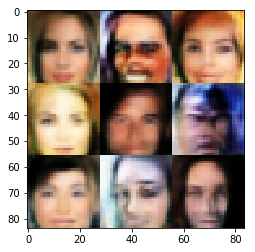

Epoch 1/5... Discriminator Loss: 1.2258... Generator Loss: 0.7722
Epoch 1/5... Discriminator Loss: 0.8519... Generator Loss: 2.0593
Epoch 1/5... Discriminator Loss: 0.8592... Generator Loss: 1.6504
Epoch 1/5... Discriminator Loss: 0.9191... Generator Loss: 1.5851
Epoch 1/5... Discriminator Loss: 1.0050... Generator Loss: 2.4897
Epoch 1/5... Discriminator Loss: 1.0254... Generator Loss: 1.1588
Epoch 1/5... Discriminator Loss: 0.8787... Generator Loss: 2.6596
Epoch 1/5... Discriminator Loss: 1.0159... Generator Loss: 1.1417
Epoch 1/5... Discriminator Loss: 1.0617... Generator Loss: 1.1154
Epoch 1/5... Discriminator Loss: 0.8724... Generator Loss: 1.6264


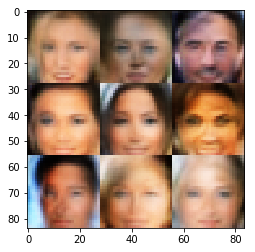

Epoch 1/5... Discriminator Loss: 1.1534... Generator Loss: 0.9543
Epoch 1/5... Discriminator Loss: 1.2070... Generator Loss: 1.1479
Epoch 1/5... Discriminator Loss: 0.8386... Generator Loss: 2.0201
Epoch 1/5... Discriminator Loss: 0.9548... Generator Loss: 1.3893
Epoch 1/5... Discriminator Loss: 0.9795... Generator Loss: 1.3098
Epoch 1/5... Discriminator Loss: 0.8073... Generator Loss: 2.2692
Epoch 1/5... Discriminator Loss: 0.9435... Generator Loss: 1.4339
Epoch 1/5... Discriminator Loss: 0.8829... Generator Loss: 1.5738
Epoch 2/5... Discriminator Loss: 1.0243... Generator Loss: 2.8084
Epoch 2/5... Discriminator Loss: 0.8795... Generator Loss: 1.6701


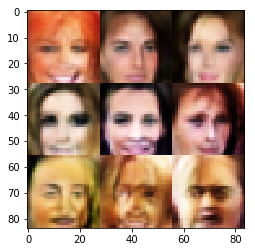

Epoch 2/5... Discriminator Loss: 0.9626... Generator Loss: 1.4178
Epoch 2/5... Discriminator Loss: 1.3961... Generator Loss: 0.6629
Epoch 2/5... Discriminator Loss: 0.7289... Generator Loss: 2.3495
Epoch 2/5... Discriminator Loss: 1.0055... Generator Loss: 2.2771
Epoch 2/5... Discriminator Loss: 0.8963... Generator Loss: 1.6635
Epoch 2/5... Discriminator Loss: 0.9737... Generator Loss: 1.2627
Epoch 2/5... Discriminator Loss: 0.9324... Generator Loss: 2.4304
Epoch 2/5... Discriminator Loss: 0.9543... Generator Loss: 1.2635
Epoch 2/5... Discriminator Loss: 0.9064... Generator Loss: 1.9557
Epoch 2/5... Discriminator Loss: 1.1682... Generator Loss: 0.8606


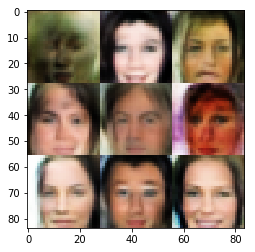

Epoch 2/5... Discriminator Loss: 0.8249... Generator Loss: 1.7297
Epoch 2/5... Discriminator Loss: 0.9227... Generator Loss: 2.5182
Epoch 2/5... Discriminator Loss: 1.0109... Generator Loss: 2.3354
Epoch 2/5... Discriminator Loss: 0.8860... Generator Loss: 2.6027
Epoch 2/5... Discriminator Loss: 1.0320... Generator Loss: 2.3657
Epoch 2/5... Discriminator Loss: 0.8523... Generator Loss: 2.3617
Epoch 2/5... Discriminator Loss: 0.9053... Generator Loss: 2.0192
Epoch 2/5... Discriminator Loss: 0.8281... Generator Loss: 2.1249
Epoch 2/5... Discriminator Loss: 0.9408... Generator Loss: 2.4125
Epoch 2/5... Discriminator Loss: 0.9375... Generator Loss: 2.0326


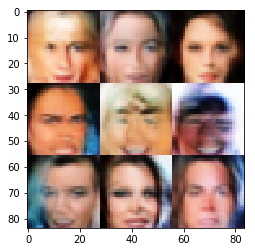

Epoch 2/5... Discriminator Loss: 1.2615... Generator Loss: 0.7274
Epoch 2/5... Discriminator Loss: 1.0604... Generator Loss: 1.0764
Epoch 2/5... Discriminator Loss: 0.8768... Generator Loss: 1.6297


KeyboardInterrupt: 

In [27]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
print_every = 10
show_every= 100


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.